# EECE7150 AFR, Homework 3

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from Mosaic import Mosaic
from Features import Features
from Pose2D import Pose2D

%load_ext autoreload
%autoreload 2

### Read images from the folder, resize and convert to grayscale

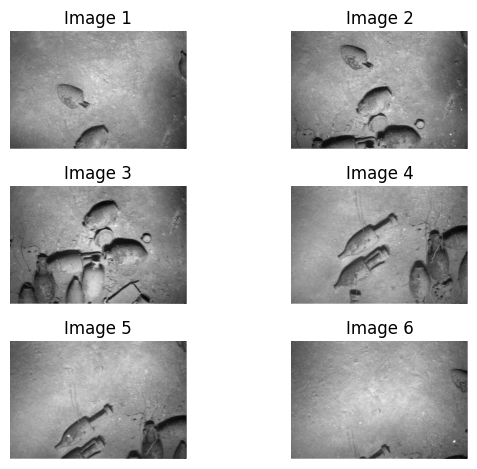

In [18]:
mosaic = Mosaic()
mosaic.read_imgs_from_folder("6Images/", resize_factor = 1, show_imgs = True)
# mosaic.read_imgs_from_folder("all columns/", resize_factor = 1, show_imgs = True)
# mosaic.read_imgs_from_folder("third_fourth column/", resize_factor = 1, show_imgs = True)

### Feature detection
I've used the SIFT detector to detect the features in the image. I also tried using ORB. Although ORB is faster, SIFT was much more good at detecting features in low contrast, low texture areas. The SIFT parameters tuned are


`nfeatures`:    The number of best features to retain. The features are ranked by their scores (measured in SIFT algorithm as the local contrast) [increased]

`contrastThreshold`:    The contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions. The larger the threshold, the less features are produced by the detector [decreased]

`edgeThreshold`:    The threshold used to filter out edge-like features. the larger the edgeThreshold, the less features are filtered out and more features are retained [increased]

`sigma`:    The sigma of the Gaussian applied to the input image. If your image is captured with a weak camera with soft lenses, you might want to reduce the number [decreased]

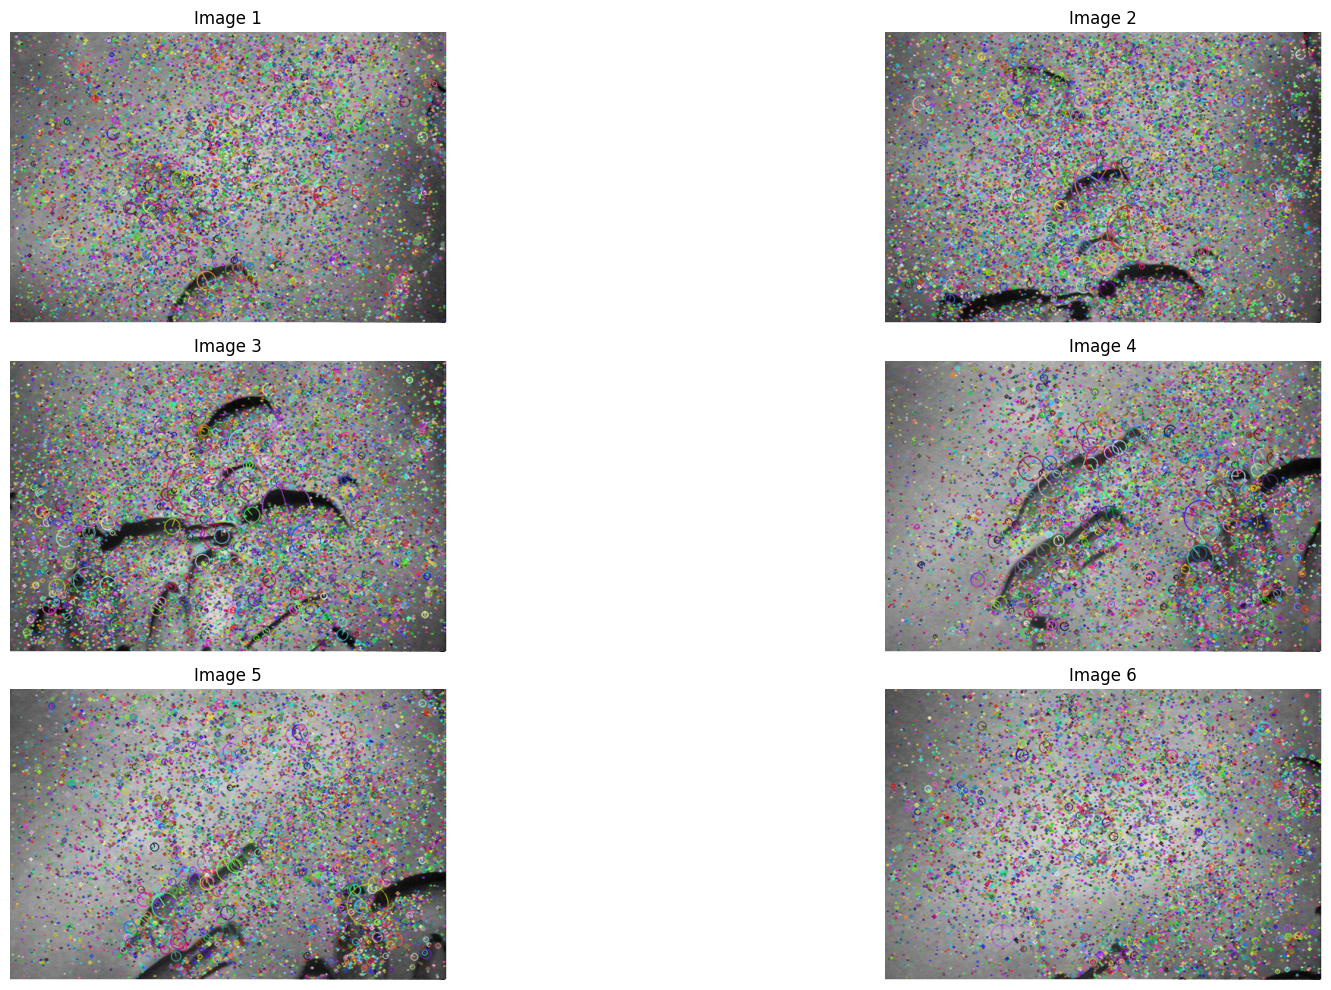

In [19]:
features = Features()
features.create_sift()
mosaic.apply_radiometric_correction()
keypoints_list, descriptor_list = features.detect_keypoints(mosaic.mosaic_imgs_gray,
                                                            mosaic.num_imgs_mosaic,
                                                            True)
                                                            

### Feature Matching and Homography computation

For feature matching, I've used the Brute-Force matcher. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned. Specifically, I've used `BFMatcher.knnMatch()` to get `k` best matches. I've taken k=2 so as to apply ratio test explained by D.Lowe in his paper. Now that we have a set of good matches, next is computing the homography.

I tried calculating the homography with and without normalization. With normalization, the mosaic turned out to be slightly better. Although the effects of drift in temporal stitching were clearly visible. For normalization, the pixel coordinated were traslated and scaled such the image lies in a unit square with the center at `(0, 0)`


If $w$ and $h$ is the width and height of the image, then normalization matrix iI used is:
$$T = \begin{bmatrix} 2/w & 0 & -1 \\ 0 & 2/h & -1 \\ 0 & 0 & 1\end{bmatrix}$$

Once the coordinates of matching points are normalized, homography is calculated using the Levenberg Marquadt algorithm, with outlier rejection using RANSAC. Once we obtain the homography, it has to be "de-normalized" before applying it on the image by
$$ H_{denorm} = T^{-1} H_{norm} T $$


### Temporal matching

In [20]:
# Best for 6 imgs
# MATCH_THRESH = 0.7
# RANSAC_THRESH = 0.02 

MATCH_THRESH = 0.8
RANSAC_THRESH = 0.02

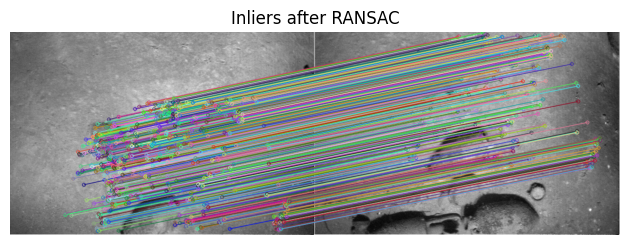

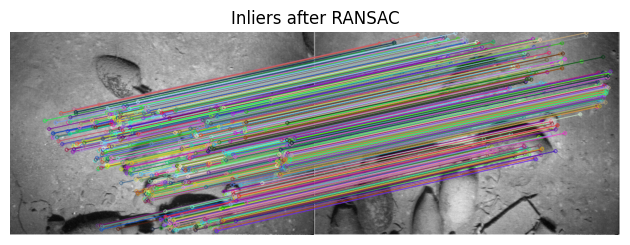

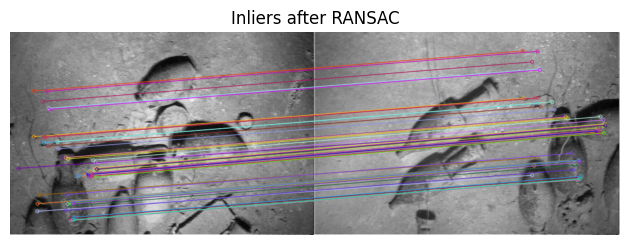

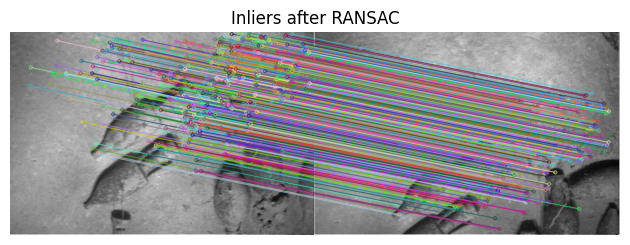

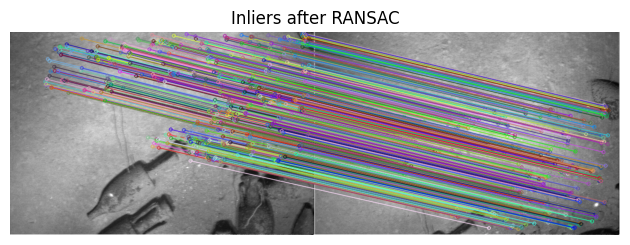

In [21]:
homographies_temporal = [np.identity(3)]
for i in range(mosaic.num_imgs_mosaic-1):
    x, x_dash, matches = features.match_features(mosaic.mosaic_imgs_gray[i], 
                                                 mosaic.mosaic_imgs_gray[i+1],
                                                 keypoints_list[i],
                                                 keypoints_list[i+1],
                                                 descriptor_list[i],
                                                 descriptor_list[i+1],
                                                 match_threshold=MATCH_THRESH,
                                                 plot=False)
    
    x_norm, x_dash_norm, T, T_dash = features.normalize(x, x_dash, mosaic.img_shape)

    H, inliers_mask = cv2.findHomography(x_dash_norm, x_norm, cv2.RANSAC, RANSAC_THRESH)

    # print(np.count_nonzero(inliers_mask))
    features.draw_inliers(inliers_mask, 
                          matches, 
                          mosaic.mosaic_imgs_gray[i], 
                          mosaic.mosaic_imgs_gray[i+1],keypoints_list[i],
                          keypoints_list[i+1])
    
    # de_norm_H = np.linalg.solve(T_dash, H@T)
    de_norm_H = np.linalg.inv(T_dash)@H@T
    homographies_temporal.append(de_norm_H)
    homographies_temporal[i+1] = homographies_temporal[i] @ homographies_temporal[i+1]

### Warped Images (Temporal)

In [22]:
min_x, min_y, max_x, max_y = mosaic.calculate_min_max_coordinates(homographies_temporal)
warped_images = mosaic.warp_images(homographies_temporal, min_x, min_y, max_x, max_y)

show_warped = False
if show_warped:
    for i in range(mosaic.num_imgs_mosaic):
        plt.figure()
        plt.imshow(warped_images[i], cmap="gray")
        plt.axis("off")

### Mosaic (Temporal)

In [50]:
panorama = np.zeros_like(warped_images[0])
canvas_mask = np.copy(panorama[:,:,0]).astype(np.uint8)
alpha = 0.3
gamma = 50

plt.figure(figsize=(12, 10))

for i in range(len(warped_images)):
    transformed_corners = mosaic.transform_img_corners(homographies_temporal[i])
    warp_mask = np.zeros_like(warped_images[0][:,:,0], dtype=np.uint8)
    cv2.fillPoly(warp_mask, [transformed_corners.astype(int)], 255)

    overlap_mask = cv2.bitwise_and(warp_mask, canvas_mask)
    not_overlap_mask = cv2.bitwise_not(overlap_mask)
    overlap_idx = np.where(overlap_mask>0)

    if np.sum(overlap_idx)>0:
        overlap_dist_transform = cv2.distanceTransform(overlap_mask, cv2.DIST_L1, 5)
        overlap_dist_transform /= np.max(overlap_dist_transform) + 1e-6
        
        # canvas_dist_transform = cv2.distanceTransform(canvas_mask, cv2.DIST_L1, 5)
        # plt.figure()
        # plt.imshow(canvas_dist_transform)
        # plt.figure()
        # plt.imshow(overlap_dist_transform+canvas_dist_transform)
        alpha_blend = overlap_dist_transform[overlap_idx].reshape(-1,1)
    
    panorama = cv2.bitwise_or(panorama, warped_images[i], mask=not_overlap_mask)
    panorama[overlap_idx] = (alpha_blend)*panorama[overlap_idx] + (1-alpha_blend)*warped_images[i][overlap_idx] + gamma
    canvas_mask = cv2.bitwise_or(canvas_mask, warp_mask)

plt.imshow(panorama)
plt.axis('off')
plt.show()

ValueError: operands could not be broadcast together with shapes (148579,) (148579,3) 

<Figure size 1200x1000 with 0 Axes>

In [39]:
alpha_blend

array([], shape=(0, 1), dtype=float32)

### Non-temporal matching

In [228]:
image_pairs = [(0, 1), (5, 0), (2, 1), (4, 2), (3, 4)]

homographies = [np.identity(3)]*mosaic.num_imgs_mosaic

for idx, (src, des) in enumerate(image_pairs):
    x, x_dash, _ = features.match_features(mosaic.mosaic_imgs_gray[src], 
                                        mosaic.mosaic_imgs_gray[des],
                                        keypoints_list[src],
                                        keypoints_list[des],
                                        descriptor_list[src],
                                        descriptor_list[des],
                                        match_threshold=MATCH_THRESH,
                                        plot = False)
    
    x_norm, x_dash_norm, T, T_dash = features.normalize(x, x_dash, mosaic.img_shape)

    H, _ = cv2.findHomography(x_norm, x_dash_norm, cv2.RANSAC, RANSAC_THRESH)
    
    de_norm_H = np.linalg.solve(T_dash, H@T)
    homographies[src] = homographies[des] @ de_norm_H

In [229]:
min_x, min_y, max_x, max_y = mosaic.calculate_min_max_coordinates(homographies)
warped_images = mosaic.warp_images(homographies, min_x, min_y, max_x, max_y)

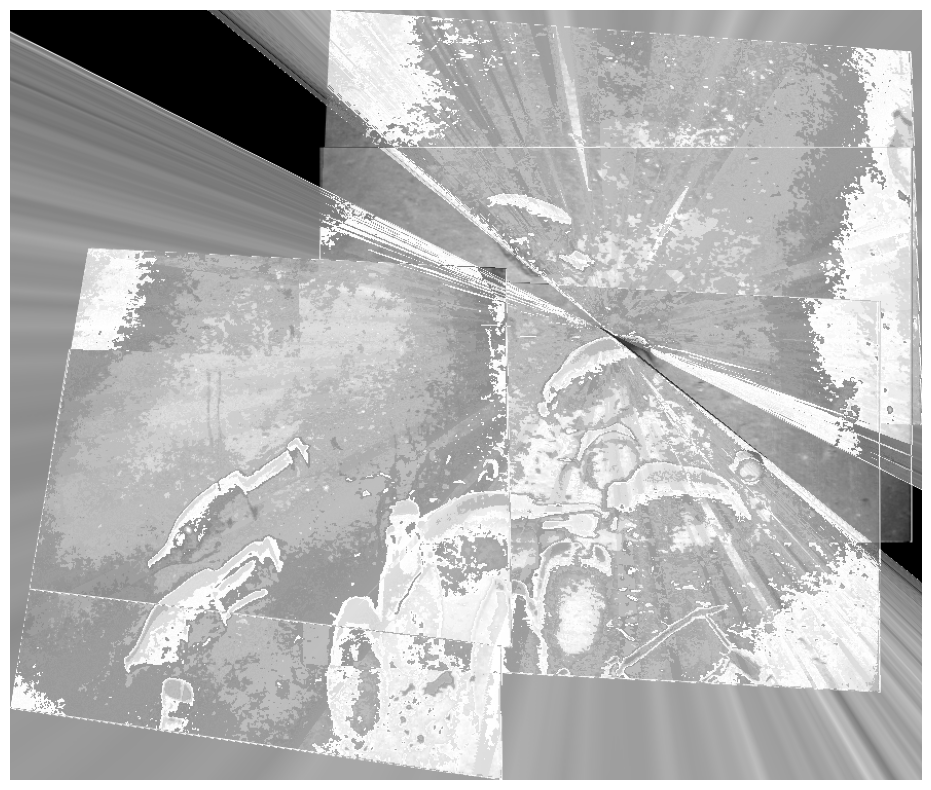

In [230]:
panorama = np.zeros_like(warped_images[0])
canvas_mask = np.copy(panorama)
alpha = 0.2
gamma = 50

plt.figure(figsize=(12, 10))

for i in range(len(warped_images)):
    transformed_corners = mosaic.transform_img_corners(homographies[i])
    warp_mask = np.zeros_like(warped_images[0])
    cv2.fillPoly(warp_mask, [transformed_corners.astype(int)], (255, 255, 255))

    overlap_mask = cv2.bitwise_and(warp_mask, canvas_mask)
    not_overlap_mask = cv2.bitwise_not(overlap_mask)
    overlap_idx = np.where(overlap_mask>0)
    
    panorama = cv2.bitwise_or(panorama, warped_images[i], mask=not_overlap_mask[:,:,0])
    panorama[overlap_idx] = (alpha)*panorama[overlap_idx] + (1-alpha)*warped_images[i][overlap_idx] + gamma
    canvas_mask = cv2.bitwise_or(canvas_mask, warp_mask)

plt.imshow(panorama)
plt.axis('off')
plt.show()

### Pose from homography

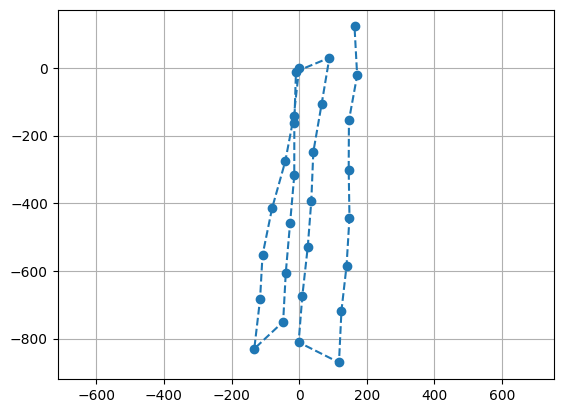

In [17]:
tx = np.array([0])
ty = np.array([0])

for i in range(mosaic.num_imgs_mosaic-1):
    x, x_dash,_ = features.match_features(mosaic.mosaic_imgs_gray[i], 
                                        mosaic.mosaic_imgs_gray[i+1],
                                        keypoints_list[i],
                                        keypoints_list[i+1],
                                        descriptor_list[i],
                                        descriptor_list[i+1],
                                        match_threshold=MATCH_THRESH,
                                        plot=False)
    
    x_norm, x_dash_norm, T, _ = features.normalize(x, x_dash, mosaic.img_shape)
    H, _ = cv2.findHomography(x_norm, x_dash_norm, cv2.RANSAC, RANSAC_THRESH)
    x, y, theta = Pose2D.get_pose_from_homography(H, T)

    tx = np.append(tx, tx[i] + x)
    ty = np.append(ty, ty[i] - y) # -y coz y axis is inverted in the image

plt.figure()
plt.plot(tx, ty, "--o")
plt.axis("equal")
plt.grid(visible=True)
plt.show()